*****************************************************************
#  Research paper
- Authors: Paul Koks, Izzie He, Lisanne van Vliet, Sam Slotemaker
- TAs: Sandro Barres-Hamers, Alexander Schmatz, Márton Bodó and Danae Mitsea.
*****************************************************************

## Cleaning our data
The one codeblock below does not need to be run, but just shows the function we used to clean our comment data

In [20]:
def filter_comments(input_file, release_date):
    try:
        data = pd.read_csv(input_file)

        # check 'publishedAt' format
        data['publishedAt'] = pd.to_datetime(data['publishedAt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        # parse the release date
        filter_date = pd.to_datetime(release_date, format='%m/%d/%y %H:%M')
        # apply filters
        filtered_data = data[(data['isReply'] == 0) & (data['publishedAt'] < filter_date)]
        # delete two empty columns 'isReplyTo' and 'isReplyToName'
        filtered_data = filtered_data.drop(columns=['isReplyTo', 'isReplyToName'], errors='ignore')
        # Rank by 'likeCount' in descending order
        filtered_data = filtered_data.sort_values(by='likeCount', ascending=False)
        # limit to the top 100 comments
        filtered_data = filtered_data.head(100)
        # generate the output file name
        base_name, ext = os.path.splitext(input_file)
        output_file = f"{base_name}_filtered{ext}"
        # Save the filtered data to a new CSV file
        filtered_data.to_csv(output_file, index=False)

        print(f"Filtered data saved to {output_file}")
    except FileNotFoundError:
        print(f"Error: The file {input_file} was not found.")
    except KeyError as e:
        print(f"Error: The column {str(e)} is not in the CSV file.")
    except Exception as e:
        print(f"An error occurred: {e}")

## Installing the needed packages
The following 2 cells install and import the needed packages


In [ ]:
!pip install nltk
!pip install scikit-learn

In [1]:
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import numpy as np
import csv
import os
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pandas as pd

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/samsloot/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Store all comments from the CSV files with their corresponding movie ID
This cell gets all data from the comment CSVs and puts it inside a map by its movie ID, so it can later be easily extracted

In [2]:
directory = 'datasets/comments'
comments_by_movie_id = {}
# all fileNames must be [movieId].csv, where movieId is the ID from the dataset row, to make this work
files_parsed = 0
for filename in os.listdir(directory):
    if filename.endswith('.csv'): 
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as file:
            csv_reader = csv.DictReader(file)
            data = [row for row in csv_reader]
            fileName = filename.split('.')[0];
            comments_by_movie_id[fileName] = data
            files_parsed += 1

print(f"All comments are parsed from {files_parsed} files and are stored inside the comments_by_movie_id variable!")

All comments are parsed from 40 files and are stored inside the comments_by_movie_id variable!


## Store the average sentiment of the trailer comments
This cell will analyse all comments and store their sentiment score

In [3]:
sid = SentimentIntensityAnalyzer()
sentiment_by_movie_id = {}

for movieId, comments in comments_by_movie_id.items():
    sentiment_total = 0
    for comment in comments:
        sentence = comment['text']
        ss = sid.polarity_scores(sentence)
        sentiment_total += ss['compound']
        average_sentiment = 0;

    # some comment files are broken so added this check to not break the code
    if len(comments) != 0:
        average_sentiment = sentiment_total / len(comments)
    else: 
        print('no comments found for:')
        print(movieId)
        
    sentiment_by_movie_id[movieId] = average_sentiment

print("All sentiments are analysed and stored inside the sentiment_by_movie_id variable!")

no comments found for:
739405
no comments found for:
840326
All sentiments are analysed and stored inside the sentiment_by_movie_id variable!


## Analysis
lets take the movies and strore them in movie_data, and define a some function that we can use later on to check the relation between variables 

In [9]:
with open('datasets/40MoviesDataSet.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    movie_data = [row for row in csv_reader]
    
def getTrailerViews(movie):
    viewCount = int(movie['viewCount'])
    return viewCount
    
def getMovieBoxOffice(movie):
    return int(movie['revenue'])

def getMovieStat(callback):
    return [callback(movie) for movie in movie_data]

def scatterPlot(xArray, xLabel, yArray, yLabel):    
    plt.scatter(xArray, yArray, s=10)
    
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    
    # Calculate correlation line
    slope, intercept, r_value, p_value, std_err = linregress(xArray, yArray)
    line = [slope * x + intercept for x in xArray]
    
    # Plot correlation line
    plt.plot(xArray, line, color='red', label=f"Fit line (R² = {r_value**2:.2f})")
    
    plt.show()

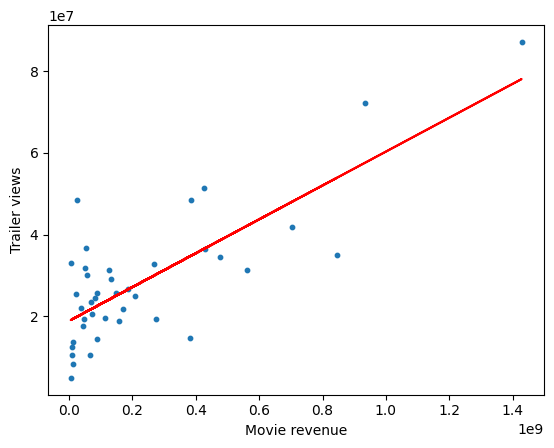

In [11]:
box_offices = getMovieStat(getMovieBoxOffice)
trailer_views = getMovieStat(getTrailerViews)

scatterPlot(box_offices, "Movie revenue", trailer_views, "Trailer views")

Is looks like there is indeed an upwards trend, regariding the trailer views and the movie revenue, lets try to see if there is a variable with a bigger correlation:

The cell below also take the trailer like ratio and sentiment score into account and shows a correlation_matrix between the variables

In [15]:
def getSentimentScore(movie):
    sentimentScore = sentiment_by_movie_id[movie['id']]
    return sentimentScore * int(movie['commentCount'])  
    
def getTrailerLikes(movie):
    return int(movie['likeCount'])

trailer_likes = getMovieStat(getTrailerLikes)
trailer_sentiment_score = getMovieStat(getSentimentScore)

x = np.column_stack((trailer_views, trailer_likes, trailer_sentiment_score))
y = np.array(box_offices)

# Create a dataframe for easier correlation analysis
data = pd.DataFrame({
    "box office": box_offices,
    "trailer views": trailer_views,
    "trailer likes": trailer_likes,
    "trailer sentiment score": trailer_sentiment_score,
})

# Compute the correlation matrix
correlation_matrix = data.corr()
print(correlation_matrix)

                         box office  trailer views  trailer likes  \
box office                 1.000000       0.775288       0.822540   
trailer views              0.775288       1.000000       0.691832   
trailer likes              0.822540       0.691832       1.000000   
trailer sentiment score    0.741577       0.611164       0.850781   

                         trailer sentiment score  
box office                              0.741577  
trailer views                           0.611164  
trailer likes                           0.850781  
trailer sentiment score                 1.000000  


We can also visualise this correlation matrix with a heatmap

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation_matrix,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

## Box office correlation
We are most interested in a correlation between variables and the box office, it looks like the strongest correlation is between box office and the amount of likes the trailer gets, lets plot this relation:

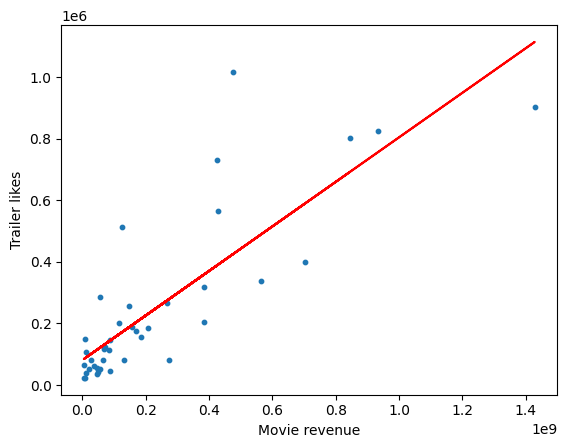

In [17]:
scatterPlot(box_offices, "Movie revenue", trailer_likes, "Trailer likes")